In [2]:
%matplotlib inline

In [3]:
import csv
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('max_columns', None)

In [4]:
# CONF = 'conf_bdlmapper_v1'
# CONF_SF = 'binning'
# CONF = 'conf_demapper_v2_{}'.format(CONF_SF)
# CONF_SF = 'none'
# CONF = 'conf_demapper_v3_{}'.format(CONF_SF)

In [5]:
import os
basedir = '/Users/dh/workspace/BDL/neurolens/experiments/cme_shine375/CME_mapper2d_data'

if os.path.isdir('/scratch'):
    basedir = '/scratch/groups/saggar/mapper/experiments/cme_shine375/CME_mapper2d_data'

files = [('', os.path.join(basedir, 'preprocessing_analysis_v1', 'dims.csv'))]

In [54]:
dists = ['cityblock', 'euclidean', 'correlation', 'chebychev']
modules = [1,2,3,4,5]
pcas = ['PCA95', 'PCA99.99', 'none']
sbjs= ['SBJ01', 'SBJ02', 'SBJ03']

res = []
for sbj in sbjs:
    for d in dists:
        for mod in modules:
            for pca in pcas:
                res.append({'sbj': sbj, 'dist': d, 'module': mod, 'pca': pca})
        
df = pd.DataFrame(res)
df

,sbj,dist,module,pca
0,SBJ01,cityblock,1,PCA95
1,SBJ01,cityblock,1,PCA99.99
2,SBJ01,cityblock,1,none
3,SBJ01,cityblock,2,PCA95
4,SBJ01,cityblock,2,PCA99.99
...,...,...,...,...
175,SBJ03,chebychev,4,PCA99.99
176,SBJ03,chebychev,4,none
177,SBJ03,chebychev,5,PCA95
178,SBJ03,chebychev,5,PCA99.99


## Combine the plots generated by matlab into one

In [193]:
def create_table(df, cols, target_metrics):
    new_table = []

    for col_vals in create_axis(df, cols):
        df_filtered = df
        for k,v in col_vals.items():
            df_filtered = df_filtered[df_filtered[k] == v]
    #     item = {k:df_filtered[k].to_numpy()[0] for k in cols}
        item = {k:v for k,v in col_vals.items()}
        for metric in target_metrics:
            item['avg_' + metric] = np.mean(df_filtered[metric])
        new_table.append(item)
    print('Found ', len(new_table))
    return new_table

In [167]:
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

sns.set(style = "whitegrid")

def create_axis(df, axis_hps, idx=0):
    if idx == len(axis_hps):
        return [{}]
    hp_name = axis_hps[idx]
    hp_vals = df[hp_name].drop_duplicates().to_numpy()
    vals = []
    hp_vals = sorted(sorted(hp_vals), key=lambda x: x != 'none')
    for hpv in hp_vals:
        df_hp = df[df[hp_name] == hpv]
        val = create_axis(df_hp, axis_hps, idx+1)
        if len(hp_vals) > 1:
            for v in val:
                v[hp_name] = hpv
        vals.extend(val)
    return vals        

def sdir(sbj):
    return os.path.join(
        basedir,
        'distances_analysis_v1')

def ax_key_toks(ax_x):
    return sorted(list(set([k for x in ax_x for k,v in x.items()])))

def plot_image(img_path, ax):
    im = Image.open(img_path)
    img = np.array(im)
    ax.imshow(img)
    del img
    del im
    return ax

# create_axis(df, ['dist'])

In [49]:


def plot_grid(df, sbj, hps_x, hps_y, hps_fixed_vals, plottype='embed', regen=False, text_f=None):
    ax_x = create_axis(df, hps_x)
    ax_y = create_axis(df, hps_y)
    
    
    x_keys = sorted(list(set([k for x in ax_x for k,v in x.items()])))
    y_keys = sorted(list(set([k for y in ax_y for k,v in y.items()])))
    fixed_toks = sorted(['{}_{}'.format(k,v) for k,v in hps_fixed_vals.items()])
    savefig_path = os.path.join(
        sdir(sbj),
        'comb{}_{}_{}.png'.format(
            '_' + plottype if plottype != 'embed' else '',
            sbj,
            '_'.join(['x'] + x_keys + ['y'] + y_keys + fixed_toks)))
    
    if os.path.isfile(savefig_path) and not regen:
        return

    ncols = len(ax_x)
    nrows = len(ax_y)
    fsize = 20
    fig, axr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fsize * (ncols/nrows)*1.1,fsize))

    for r,(y,axc) in enumerate(zip(ax_y,axr)):
        for c,(x,ax) in enumerate(zip(ax_x,axc)):
            K = {'sbj':sbj, **x, **y, **hps_fixed_vals}
            df_filtered = df
            for k,v in K.items():
                df_filtered = df_filtered[df_filtered[k] == v]
            if len(df_filtered) == 0:
                print('none')
                ax.axis('off')
                continue
            assert len(df_filtered) == 1, 'Too many ({}) items found for {}, {}, {}'.format(
                len(df_filtered), x, y, hps_fixed_vals)
            item = df_filtered
            sbj = item['sbj'].to_numpy()[0]
#             idx = int(item['idx'].to_numpy()[0])


            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
            if r == len(ax_y)-1:
                ax.set_xlabel(' '.join([str(x[k]) for k in hps_x if k in x]))
                ax.xaxis.set_label_position("bottom")
            if c == 0:
                ax.set_ylabel(' '.join([str(y[k]) for k in hps_y if k in y]))

            img_path = os.path.join(
                sdir(sbj),
                'hist_{}_{}_{}_{}.png'.format(
                    item['sbj'].to_list()[0],
                    item['dist'].to_list()[0],
                    item['module'].to_list()[0],
                    item['pca'].to_list()[0]))
            if not os.path.isfile(img_path):
    #             ax.axis('off')
                continue
        
#             modd = df_filtered[['preembed_mod_full', 'preembed_mod_wout_ac', 'embed_modd_bin', 'embed_modd_wout_ac']].to_numpy()[0]
#             modd = [str(round(m,3)) for m in modd]
#             title = ' -> '.join([', '.join(modd[0:2]), ', '.join(modd[2:4])])
#             ax.set_title(title)
            if text_f:
                ax = text_f(ax, item)
            ax = plot_image(img_path, ax)
    plt.tight_layout()
    
    plt.savefig(savefig_path, dpi=150)
#     plt.show()
    plt.close()



In [55]:

for sbj in tqdm(sbjs):
    for pca in pcas:
        plot_grid(df, sbj, ['dist'], ['module'], {'pca': pca}, regen=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.07s/it]


In [28]:
df

,sbj,dist,module
0,SBJ01,cityblock,1
1,SBJ01,cityblock,2
2,SBJ01,cityblock,3
3,SBJ01,cityblock,4
4,SBJ01,cityblock,5
5,SBJ01,euclidean,1
6,SBJ01,euclidean,2
7,SBJ01,euclidean,3
8,SBJ01,euclidean,4
9,SBJ01,euclidean,5


# reciprocal kNN analysis

In [16]:
rknn_dir = os.path.join(basedir, 'rknn_analysis_v1')

data = []
for fpath in sorted(os.listdir(rknn_dir)):
    if fpath.endswith('.csv') and fpath.startswith('edges_cnt'):
        print(fpath)
        edges_fpath = os.path.join(rknn_dir, fpath)

        with open(edges_fpath) as f:
            for row in csv.DictReader(f):
                R = {}
                for k,v in row.items():
                    try:
                        R[k] = float(v)
                    except:
                        R[k] = v;
                data.append(R)

df = pd.DataFrame(data=data)
df

edges_cnts_SBJ01.csv
edges_cnts_SBJ02.csv
edges_cnts_SBJ03.csv
edges_cnts_SBJ04.csv
edges_cnts_SBJ06.csv
edges_cnts_SBJ07.csv
edges_cnts_SBJ08.csv
edges_cnts_SBJ09.csv
edges_cnts_SBJ10.csv
edges_cnts_SBJ12.csv
edges_cnts_SBJ13.csv
edges_cnts_SBJ14.csv
edges_cnts_SBJ15.csv
edges_cnts_SBJ16.csv
edges_cnts_SBJ17.csv
edges_cnts_SBJ18.csv
edges_cnts_SBJ19.csv
edges_cnts_SBJ20.csv


,sbj,pca,dist,k,knntype,totaledges,edgs1->1,edgs1->2,edgs1->3,edgs1->4,edgs1->5,edgs2->2,edgs2->3,edgs2->4,edgs2->5,edgs3->3,edgs3->4,edgs3->5,edgs4->4,edgs4->5,edgs5->5
0,SBJ01,PCA95,cityblock,64.0,bin,11476.0,116.0,19.0,58.0,26.0,38.0,679.0,271.0,234.0,170.0,2314.0,1222.0,2358.0,1099.0,1148.0,1724.0
1,SBJ01,PCA95,cityblock,64.0,wtd,11476.0,116.0,19.0,58.0,26.0,38.0,679.0,271.0,234.0,170.0,2314.0,1222.0,2358.0,1099.0,1148.0,1724.0
2,SBJ01,PCA95,cityblock,32.0,bin,5857.0,106.0,14.0,28.0,15.0,18.0,599.0,69.0,79.0,47.0,1391.0,446.0,862.0,736.0,392.0,1055.0
3,SBJ01,PCA95,cityblock,32.0,wtd,5857.0,106.0,14.0,28.0,15.0,18.0,599.0,69.0,79.0,47.0,1391.0,446.0,862.0,736.0,392.0,1055.0
4,SBJ01,PCA95,cityblock,16.0,bin,3512.0,103.0,13.0,18.0,10.0,13.0,558.0,19.0,16.0,15.0,899.0,136.0,274.0,585.0,132.0,721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,SBJ20,none,spearman,32.0,wtd,9839.0,214.0,161.0,178.0,154.0,182.0,1479.0,243.0,763.0,663.0,1366.0,498.0,863.0,1244.0,643.0,1188.0
3020,SBJ20,none,spearman,16.0,bin,4831.0,163.0,45.0,77.0,73.0,53.0,892.0,58.0,261.0,188.0,835.0,141.0,303.0,765.0,210.0,767.0
3021,SBJ20,none,spearman,16.0,wtd,4831.0,163.0,45.0,77.0,73.0,53.0,892.0,58.0,261.0,188.0,835.0,141.0,303.0,765.0,210.0,767.0
3022,SBJ20,none,spearman,8.0,bin,2730.0,123.0,15.0,28.0,30.0,15.0,612.0,11.0,42.0,31.0,571.0,30.0,74.0,560.0,47.0,541.0


In [35]:
# dists = df['dist'].drop_duplicates().to_numpy()
dists = ['cityblock', 'correlation', 'euclidean']

dist = 'cityblock'
pcatype = 'none'
k = 8
knntype = 'wtd'
# for dist in dists:
df[(df['pca'] == pcatype) & (df['k'] == k) & (df['dist'] == dist) & (df['knntype'] == knntype)].describe()

,k,totaledges,edgs1->1,edgs1->2,edgs1->3,edgs1->4,edgs1->5,edgs2->2,edgs2->3,edgs2->4,edgs2->5,edgs3->3,edgs3->4,edgs3->5,edgs4->4,edgs4->5,edgs5->5
count,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,8.0,2376.166667,85.611111,12.000000,12.555556,12.722222,12.833333,473.444444,11.333333,18.166667,15.500000,594.222222,29.166667,96.277778,460.166667,35.277778,506.888889
std,0.0,131.556407,7.616846,4.029304,4.047108,5.929047,4.604985,48.213035,10.238336,12.267844,8.023861,36.974642,15.986207,27.413620,38.731732,14.310858,38.432353
min,8.0,2145.000000,72.000000,6.000000,7.000000,6.000000,6.000000,394.000000,0.000000,4.000000,2.000000,498.000000,8.000000,39.000000,413.000000,8.000000,462.000000
25%,8.0,2306.000000,81.000000,9.000000,8.500000,9.000000,9.250000,449.250000,1.750000,8.500000,10.000000,568.000000,15.750000,83.000000,433.750000,24.000000,470.250000
50%,8.0,2364.500000,86.000000,11.000000,13.000000,10.500000,12.000000,464.000000,10.500000,15.000000,16.500000,602.000000,27.000000,100.500000,453.500000,35.000000,502.000000
75%,8.0,2443.250000,90.250000,15.000000,14.750000,17.000000,15.000000,490.250000,15.750000,22.000000,19.750000,623.500000,39.750000,107.000000,471.250000,46.000000,531.000000
max,8.0,2692.000000,98.000000,20.000000,20.000000,24.000000,22.000000,585.000000,34.000000,47.000000,33.000000,643.000000,68.000000,160.000000,564.000000,58.000000,583.000000


array(['PCA95', 'PCA99.99', 'none'], dtype=object)

In [187]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set(style = "whitegrid")

dists = ['cityblock', 'correlation', 'euclidean', 'chebychev']
pcatypes = df['pca'].drop_duplicates().to_numpy()
ks = df['k'].drop_duplicates().to_numpy()
knntypes = df['knntype'].drop_duplicates().to_numpy()
tasks = ['Instruction', 'Rest', 'Memory', 'Video', 'Math']

for dist in dists:
    for pcatype in pcatypes:
        for k in ks:
            for knntype in knntypes:
                # for dist in dists:
                df_filtered = df[(df['pca'] == pcatype) & (df['k'] == k) & (df['dist'] == dist) & (df['knntype'] == knntype)]
                df_means = df_filtered.describe().iloc[[1]]
                assert df_means.index[0] == 'mean'

                for percs in [False, True]:

                    edg_total = df_means['totaledges'].to_numpy()[0]
                    edgs = np.zeros((len(tasks),len(tasks)))
                    for i1 in range(len(tasks)):
                        for i2 in range(i1, len(tasks)):
                            edgs[i1][i2] = df_means['edgs{}->{}'.format(i1+1, i2+1)].to_numpy()[0]

                    edgs[edgs == 0] = np.nan
                    edgs = edgs.T
                    if percs:
                        edgs = (edgs / edg_total) * 100

                    fig, ax = plt.subplots()

                    vmax = 100.0 if percs else np.max(edgs[edgs > 0])
                    im = ax.imshow(edgs,
                                   cmap='hot' if percs else 'copper',
                                   vmax=vmax)

                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes('right', size='5%', pad=0.05)
                    fig.colorbar(im, cax=cax, orientation='vertical')

                    ax.set_xticks(range(len(tasks)))
                    ax.set_xticklabels(tasks)
                    ax.set_yticks(range(len(tasks)))
                    ax.set_yticklabels(tasks)
                    ax.set_title('Edges count for {} of {} rKNN k={}'.format(dist, knntype, k))
                    ax.grid(False)
                    # ax.set_yticks(range(len(tasks)), labels=tasks)
                    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                             rotation_mode="anchor")

                    # Loop over data dimensions and create text annotations.
                    for i in range(len(tasks)):
                        for j in range(len(tasks)):
                            text = ax.text(j, i, round(edgs[i, j], 1),
                                           ha="center", va="center", color="w")

                    savefig_path = os.path.join(rknn_dir, 'plot_edgs_{}_{}_{}_{}_{}.png'.format(
                        'percs' if percs else 'cnts', dist, pcatype, k, knntype))
                    plt.savefig(savefig_path, dpi=150)
                #     plt.show()
                    plt.close()

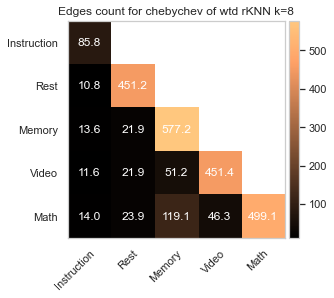

In [186]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style = "whitegrid")

dist='chebychev'
pcatype = 'none'
k = 8
knntype = 'wtd'
# for dist in dists:
df_filtered = df[(df['pca'] == pcatype) & (df['k'] == k) & (df['dist'] == dist) & (df['knntype'] == knntype)]
df_means = df_filtered.describe().iloc[[1]]
assert df_means.index[0] == 'mean'

edg_total = df_means['totaledges'].to_numpy()[0]
edg_total
tasks = ['Instruction', 'Rest', 'Memory', 'Video', 'Math']
edgs = np.zeros((len(tasks),len(tasks)))
for i1 in range(len(tasks)):
    for i2 in range(i1, len(tasks)):
        edgs[i1][i2] = df_means['edgs{}->{}'.format(i1+1, i2+1)].to_numpy()[0]

edgs[edgs == 0] = np.nan
edgs = edgs.T

fig, ax = plt.subplots()

im = ax.imshow(edgs, cmap='copper')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xticks(range(len(tasks)))
ax.set_xticklabels(tasks)
ax.set_yticks(range(len(tasks)))
ax.set_yticklabels(tasks)
ax.set_title('Edges count for {} of {} rKNN k={}'.format(dist, knntype, k))
# ax.set_yticks(range(len(tasks)), labels=tasks)
ax.grid(False)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(tasks)):
    for j in range(len(tasks)):
        text = ax.text(j, i, round(edgs[i, j], 1),
                       ha="center", va="center", color="w")

plt.show()

In [191]:


def plot_grid_edgs(df, hps_x, hps_y, hps_fixed_vals, text_f=None, plottype='cnts'):
    ax_x = create_axis(df, hps_x)
    ax_y = create_axis(df, hps_y)
    
    
    x_keys = sorted(list(set([k for x in ax_x for k,v in x.items()])))
    y_keys = sorted(list(set([k for y in ax_y for k,v in y.items()])))
    fixed_toks = sorted(['{}_{}'.format(k,v) for k,v in hps_fixed_vals.items()])
    savefig_path = os.path.join(
        rknn_dir,
        'comb_{}_{}.png'.format(
            plottype,
            '_'.join(['x'] + x_keys + ['y'] + y_keys + fixed_toks)))

    ncols = len(ax_x)
    nrows = len(ax_y)
    fsize = 20
    fig, axr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fsize * (ncols/nrows)*1.1,fsize))

    for r,(y,axc) in enumerate(zip(ax_y,axr)):
        for c,(x,ax) in enumerate(zip(ax_x,axc)):
            K = {**x, **y, **hps_fixed_vals}
            df_filtered = df
            for k,v in K.items():
                df_filtered = df_filtered[df_filtered[k] == v]
            if len(df_filtered) == 0:
                print('none')
                ax.axis('off')
                continue
            assert len(df_filtered) == 1, 'Too many ({}) items found for {}, {}, {}'.format(
                len(df_filtered), x, y, hps_fixed_vals)
            item = df_filtered
#             idx = int(item['idx'].to_numpy()[0])


            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
            if r == len(ax_y)-1:
                ax.set_xlabel(' '.join([str(x[k]) for k in hps_x if k in x]))
                ax.xaxis.set_label_position("bottom")
            if c == 0:
                ax.set_ylabel(' '.join([str(y[k]) for k in hps_y if k in y]))

            img_path = os.path.join(
                rknn_dir,
                'plot_edgs_{}_{}_{}_{}_{}.png'.format(
                    plottype,
                    item['dist'].to_list()[0],
                    item['pca'].to_list()[0],
                    item['k'].to_list()[0],
                    item['knntype'].to_list()[0]))
            if not os.path.isfile(img_path):
    #             ax.axis('off')
                continue
        
#             modd = df_filtered[['preembed_mod_full', 'preembed_mod_wout_ac', 'embed_modd_bin', 'embed_modd_wout_ac']].to_numpy()[0]
#             modd = [str(round(m,3)) for m in modd]
#             title = ' -> '.join([', '.join(modd[0:2]), ', '.join(modd[2:4])])
#             ax.set_title(title)
            if text_f:
                ax = text_f(ax, item)
            ax = plot_image(img_path, ax)
    plt.tight_layout()
    
    plt.savefig(savefig_path, dpi=150)
#     plt.show()
    plt.close()



In [192]:
df_sep = df[['pca', 'dist', 'k', 'knntype']].drop_duplicates()
df_sep = df_sep[df_sep['dist'].isin(dists)]

for pcatype in pcatypes:
    for knntype in knntypes:
        for plottype in ['cnts', 'percs']:
            plot_grid_edgs(df_sep, ['k'], ['dist'], {'knntype': knntype, 'pca': pcatype}, plottype=plottype)

In [194]:
df.apply(lambda row: row[])

,sbj,pca,dist,k,knntype,totaledges,edgs1->1,edgs1->2,edgs1->3,edgs1->4,edgs1->5,edgs2->2,edgs2->3,edgs2->4,edgs2->5,edgs3->3,edgs3->4,edgs3->5,edgs4->4,edgs4->5,edgs5->5
0,SBJ01,PCA95,cityblock,64.0,bin,11476.0,116.0,19.0,58.0,26.0,38.0,679.0,271.0,234.0,170.0,2314.0,1222.0,2358.0,1099.0,1148.0,1724.0
1,SBJ01,PCA95,cityblock,64.0,wtd,11476.0,116.0,19.0,58.0,26.0,38.0,679.0,271.0,234.0,170.0,2314.0,1222.0,2358.0,1099.0,1148.0,1724.0
2,SBJ01,PCA95,cityblock,32.0,bin,5857.0,106.0,14.0,28.0,15.0,18.0,599.0,69.0,79.0,47.0,1391.0,446.0,862.0,736.0,392.0,1055.0
3,SBJ01,PCA95,cityblock,32.0,wtd,5857.0,106.0,14.0,28.0,15.0,18.0,599.0,69.0,79.0,47.0,1391.0,446.0,862.0,736.0,392.0,1055.0
4,SBJ01,PCA95,cityblock,16.0,bin,3512.0,103.0,13.0,18.0,10.0,13.0,558.0,19.0,16.0,15.0,899.0,136.0,274.0,585.0,132.0,721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,SBJ20,none,spearman,32.0,wtd,9839.0,214.0,161.0,178.0,154.0,182.0,1479.0,243.0,763.0,663.0,1366.0,498.0,863.0,1244.0,643.0,1188.0
3020,SBJ20,none,spearman,16.0,bin,4831.0,163.0,45.0,77.0,73.0,53.0,892.0,58.0,261.0,188.0,835.0,141.0,303.0,765.0,210.0,767.0
3021,SBJ20,none,spearman,16.0,wtd,4831.0,163.0,45.0,77.0,73.0,53.0,892.0,58.0,261.0,188.0,835.0,141.0,303.0,765.0,210.0,767.0
3022,SBJ20,none,spearman,8.0,bin,2730.0,123.0,15.0,28.0,30.0,15.0,612.0,11.0,42.0,31.0,571.0,30.0,74.0,560.0,47.0,541.0


In [197]:
# create_table(df, ['pca', 'dist', 'k'], '')
df

,sbj,pca,dist,k,knntype,totaledges,edgs1->1,edgs1->2,edgs1->3,edgs1->4,edgs1->5,edgs2->2,edgs2->3,edgs2->4,edgs2->5,edgs3->3,edgs3->4,edgs3->5,edgs4->4,edgs4->5,edgs5->5
0,SBJ01,PCA95,cityblock,64.0,bin,11476.0,116.0,19.0,58.0,26.0,38.0,679.0,271.0,234.0,170.0,2314.0,1222.0,2358.0,1099.0,1148.0,1724.0
1,SBJ01,PCA95,cityblock,64.0,wtd,11476.0,116.0,19.0,58.0,26.0,38.0,679.0,271.0,234.0,170.0,2314.0,1222.0,2358.0,1099.0,1148.0,1724.0
2,SBJ01,PCA95,cityblock,32.0,bin,5857.0,106.0,14.0,28.0,15.0,18.0,599.0,69.0,79.0,47.0,1391.0,446.0,862.0,736.0,392.0,1055.0
3,SBJ01,PCA95,cityblock,32.0,wtd,5857.0,106.0,14.0,28.0,15.0,18.0,599.0,69.0,79.0,47.0,1391.0,446.0,862.0,736.0,392.0,1055.0
4,SBJ01,PCA95,cityblock,16.0,bin,3512.0,103.0,13.0,18.0,10.0,13.0,558.0,19.0,16.0,15.0,899.0,136.0,274.0,585.0,132.0,721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,SBJ20,none,spearman,32.0,wtd,9839.0,214.0,161.0,178.0,154.0,182.0,1479.0,243.0,763.0,663.0,1366.0,498.0,863.0,1244.0,643.0,1188.0
3020,SBJ20,none,spearman,16.0,bin,4831.0,163.0,45.0,77.0,73.0,53.0,892.0,58.0,261.0,188.0,835.0,141.0,303.0,765.0,210.0,767.0
3021,SBJ20,none,spearman,16.0,wtd,4831.0,163.0,45.0,77.0,73.0,53.0,892.0,58.0,261.0,188.0,835.0,141.0,303.0,765.0,210.0,767.0
3022,SBJ20,none,spearman,8.0,bin,2730.0,123.0,15.0,28.0,30.0,15.0,612.0,11.0,42.0,31.0,571.0,30.0,74.0,560.0,47.0,541.0


In [211]:
new_table = []
cols = ['pca', 'dist', 'k']
for col_vals in create_axis(df, ['sbj'] + cols):
    df_filtered = df
    for k,v in col_vals.items():
        df_filtered = df_filtered[df_filtered[k] == v]
#     item = {k:df_filtered[k].to_numpy()[0] for k in cols}
    item = {k:v for k,v in col_vals.items()}
    assert len(df_filtered) == 2
    bin_df = df_filtered[df_filtered['knntype'] == 'bin']
    wtd_df = df_filtered[df_filtered['knntype'] == 'wtd']
    bin_edgs = bin_df['totaledges'].to_numpy()[0]
    wtd_edgs = wtd_df['totaledges'].to_numpy()[0]
    item['added_wtd'] = wtd_edgs - bin_edgs
    new_table.append(item)
    
dfcomb = pd.DataFrame(new_table)

pd.set_option('display.max_rows', None)
df_avged = pd.DataFrame(create_table(dfcomb, cols, ['added_wtd']))


Found  84


In [212]:
df_avged[df_avged['dist'].isin(['cityblock', 'correlation', 'euclidean'])]

,k,dist,pca,avg_added_wtd
4,8.0,cityblock,none,2.722222
5,16.0,cityblock,none,0.888889
6,32.0,cityblock,none,0.166667
7,64.0,cityblock,none,0.111111
8,8.0,correlation,none,0.000000
9,16.0,correlation,none,0.000000
10,32.0,correlation,none,0.000000
11,64.0,correlation,none,0.000000
16,8.0,euclidean,none,0.555556
17,16.0,euclidean,none,0.388889


In [283]:
rknn_dir = os.path.join(basedir, 'rknn_analysis_v2')

data = []
for fpath in sorted(os.listdir(rknn_dir)):
    if fpath.endswith('.csv') and fpath.startswith('fit_distribs_'):
        print(fpath)
        edges_fpath = os.path.join(rknn_dir, fpath)

        with open(edges_fpath) as f:
            for row in csv.DictReader(f):
                R = {}
                for k,v in row.items():
                    try:
                        R[k] = float(v)
                    except:
                        R[k] = v;
                data.append(R)

df = pd.DataFrame(data=data)

fit_distribs_SBJ01.csv
fit_distribs_SBJ02.csv
fit_distribs_SBJ03.csv
fit_distribs_SBJ04.csv
fit_distribs_SBJ06.csv
fit_distribs_SBJ07.csv
fit_distribs_SBJ08.csv
fit_distribs_SBJ09.csv
fit_distribs_SBJ10.csv
fit_distribs_SBJ12.csv
fit_distribs_SBJ13.csv
fit_distribs_SBJ14.csv
fit_distribs_SBJ15.csv
fit_distribs_SBJ16.csv
fit_distribs_SBJ17.csv
fit_distribs_SBJ18.csv
fit_distribs_SBJ19.csv
fit_distribs_SBJ20.csv


In [284]:
df['UseNormal'] = df.apply(lambda row: 1 if row['Normal_err'] < row['Gamma_err'] else 0, axis=1)
df['mean'] = df.apply(lambda row: row['Normal_mu'] if row['UseNormal'] else row['Gamma_a'] * row['Gamma_b'], axis=1)
df['std'] = df.apply(lambda row: row['Normal_sigma'] if row['UseNormal'] else np.sqrt(row['Gamma_a'] * (row['Gamma_b'] ** 2)), axis=1)
df['err'] = df.apply(lambda row: row['Normal_err'] if row['UseNormal'] else row['Gamma_err'], axis=1)

In [286]:
df_comb = pd.DataFrame(create_table(df, ['pca', 'dist'], ['mean', 'std', 'UseNormal', 'err']))
df_comb = df_comb[df_comb['dist'].isin(['cityblock', 'correlation', 'euclidean'])]
df_comb = df_comb.sort_values(by=['dist', 'pca'])

Found  42


In [289]:
df_comb.to_csv(os.path.join(rknn_dir, 'combined_pca_analysis.csv'))
df_total = df_comb

In [290]:
df[(df['pca'] == 'PCA99') & (df['dist'] == 'cityblock')]

,sbj,pca,dist,Gamma_a,Gamma_b,Gamma_err,Normal_mu,Normal_sigma,Normal_err,UseNormal,mean,std,err
21,SBJ01,PCA99,cityblock,55.8986,2.88364,0.062990,161.1913,20.89652,0.076128,0,161.191439,21.559640,0.062990
63,SBJ02,PCA99,cityblock,34.9765,4.17206,0.041712,145.9238,24.27576,0.097866,0,145.924057,24.673952,0.041712
105,SBJ03,PCA99,cityblock,35.2643,4.32093,0.052503,152.3747,25.30553,0.112630,0,152.374572,25.659304,0.052503
147,SBJ04,PCA99,cityblock,52.1487,3.04529,0.060175,158.8080,21.36900,0.077854,0,158.807915,21.991275,0.060175
189,SBJ06,PCA99,cityblock,69.9285,2.36201,0.115500,165.1719,19.00722,0.112080,1,165.171900,19.007220,0.112080
231,SBJ07,PCA99,cityblock,51.2251,3.17576,0.067074,162.6782,22.21016,0.102570,0,162.678624,22.729458,0.067074
273,SBJ08,PCA99,cityblock,41.8111,3.41993,0.051373,142.9908,21.58442,0.081675,0,142.991035,22.113781,0.051373
315,SBJ09,PCA99,cityblock,36.3272,3.60533,0.048041,130.9713,21.27762,0.080499,0,130.971544,21.730063,0.048041
357,SBJ10,PCA99,cityblock,51.5468,2.94164,0.073726,151.6322,20.43565,0.055614,1,151.632200,20.435650,0.055614
399,SBJ12,PCA99,cityblock,45.9002,3.05063,0.074108,140.0246,20.03734,0.075809,0,140.024527,20.667923,0.074108


In [291]:
rknn_dir = os.path.join(basedir, 'rknn_analysis_v2')

data = []
for fpath in sorted(os.listdir(rknn_dir)):
    if fpath.endswith('.csv') and fpath.startswith('fit_tasks_distribs_'):
        print(fpath)
        edges_fpath = os.path.join(rknn_dir, fpath)

        with open(edges_fpath) as f:
            for row in csv.DictReader(f):
                R = {}
                for k,v in row.items():
                    try:
                        R[k] = float(v)
                    except:
                        R[k] = v;
                data.append(R)

df = pd.DataFrame(data=data)

fit_tasks_distribs_SBJ01.csv
fit_tasks_distribs_SBJ02.csv
fit_tasks_distribs_SBJ03.csv
fit_tasks_distribs_SBJ04.csv
fit_tasks_distribs_SBJ06.csv
fit_tasks_distribs_SBJ07.csv
fit_tasks_distribs_SBJ08.csv
fit_tasks_distribs_SBJ09.csv
fit_tasks_distribs_SBJ10.csv
fit_tasks_distribs_SBJ12.csv
fit_tasks_distribs_SBJ13.csv
fit_tasks_distribs_SBJ14.csv
fit_tasks_distribs_SBJ15.csv
fit_tasks_distribs_SBJ16.csv
fit_tasks_distribs_SBJ17.csv
fit_tasks_distribs_SBJ18.csv
fit_tasks_distribs_SBJ19.csv
fit_tasks_distribs_SBJ20.csv


In [292]:

df['UseNormal'] = df.apply(lambda row: 1 if row['Normal_err'] < row['Gamma_err'] else 0, axis=1)
df['mean'] = df.apply(lambda row: row['Normal_mu'] if row['UseNormal'] else row['Gamma_a'] * row['Gamma_b'], axis=1)
df['std'] = df.apply(lambda row: row['Normal_sigma'] if row['UseNormal'] else np.sqrt(row['Gamma_a'] * (row['Gamma_b'] ** 2)), axis=1)
df['err'] = df.apply(lambda row: row['Normal_err'] if row['UseNormal'] else row['Gamma_err'], axis=1)

In [293]:
df_comb = pd.DataFrame(create_table(df, ['pca', 'dist', 'tasks'], ['mean', 'std', 'UseNormal', 'err']))
df_comb = df_comb[df_comb['dist'].isin(['cityblock', 'correlation', 'euclidean'])]
df_comb = df_comb.sort_values(by=['dist', 'pca'])

Found  630


In [294]:
df_comb[df_comb['pca'] == 'none']

,tasks,dist,pca,avg_mean,avg_std,avg_UseNormal,avg_err
15,1->1,cityblock,none,412.583706,125.284365,1.000000,1.466589
16,1->2,cityblock,none,454.780994,124.845285,1.000000,1.508994
17,1->3,cityblock,none,408.471711,117.212478,1.000000,1.517467
18,1->4,cityblock,none,431.789833,118.335390,1.000000,1.534578
19,1->5,cityblock,none,424.893178,123.629674,1.000000,1.497028
20,2->2,cityblock,none,421.264222,120.494948,1.000000,1.501311
21,2->3,cityblock,none,372.818006,103.273783,1.000000,1.556122
22,2->4,cityblock,none,401.886989,105.446748,1.000000,1.584994
23,2->5,cityblock,none,391.446650,110.523338,1.000000,1.531789
24,3->3,cityblock,none,310.562039,95.367903,1.000000,1.524189


In [315]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style = "whitegrid")

dist='cityblock'
pcatype = 'none'
target_metric = 'avg_mean'
pcatypes = df_comb['pca'].drop_duplicates().to_list()
target_metrics = ['avg_mean', 'avg_std', 'avg_UseNormal', 'avg_err']

def get_heatmap(df, dist, pcatype, target_metric):
    df_filtered = df[(df['pca'] == pcatype) & (df['dist'] == dist)]

    tasks = ['Instruction', 'Rest', 'Memory', 'Video', 'Math']
    heatmap = np.zeros((len(tasks),len(tasks)))
    for i1 in range(len(tasks)):
        for i2 in range(i1, len(tasks)):
            heatmap[i1][i2] = df_filtered[df_filtered['tasks'] == '{}->{}'.format(i1+1, i2+1)][target_metric].to_numpy()[0]

    heatmap[heatmap == 0] = np.nan
    heatmap = heatmap.T
    return heatmap

for dist in ['cityblock', 'correlation', 'euclidean']:
    for pcatype in pcatypes:
        for target_metric in target_metrics:

            heatmap = get_heatmap(df_comb, dist, pcatype, target_metric)
            total = df_total[(df_total['dist'] == dist) & (df_total['pca'] == pcatype)]
            total = total[target_metric].to_numpy()[0]

            fig, ax = plt.subplots()

            im = ax.imshow(heatmap, cmap='copper')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im, cax=cax, orientation='vertical')

            original_ticks = list(cbar.get_ticks())
            cbar.set_ticks(original_ticks + [total])
            cbar.set_ticklabels(original_ticks + ['All'])

            ax.set_xticks(range(len(tasks)))
            ax.set_xticklabels(tasks)
            ax.set_yticks(range(len(tasks)))
            ax.set_yticklabels(tasks)
            ax.set_title('{} for {} pca={}'.format(target_metric, dist, pcatype))
            # ax.set_yticks(range(len(tasks)), labels=tasks)
            ax.grid(False)
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(tasks)):
                for j in range(len(tasks)):
                    text = ax.text(j, i, round(heatmap[i, j], 1),
                                   ha="center", va="center", color="w")

            savefig_path = os.path.join(
                rknn_dir,
                'heatmap_{}_on_{}_{}.png'.format(target_metric, dist, pcatype))
#             plt.show()
            plt.savefig(savefig_path, dpi=150)
            plt.close()

In [311]:
rknn_dir

'/Users/dh/workspace/BDL/neurolens/experiments/cme_shine375/CME_mapper2d_data/rknn_analysis_v2'

In [333]:
sorted(['none', 'PCA90'])

['PCA90', 'none']

In [425]:


def create_axis(df, axis_hps, idx=0):
    if idx == len(axis_hps):
        return [{}]
    hp_name = axis_hps[idx]
    hp_vals = df[hp_name].drop_duplicates().to_numpy()
    vals = []
    hp_vals = sorted(hp_vals)
    for hpv in hp_vals:
        df_hp = df[df[hp_name] == hpv]
        val = create_axis(df_hp, axis_hps, idx+1)
        if len(hp_vals) > 1:
            for v in val:
                v[hp_name] = hpv
        vals.extend(val)
    return vals       

def plot_grid_heatmaps(df, hps_x, hps_y, hps_fixed_vals, text_f=None, plottype='avg_mean'):
    ax_x = create_axis(df, hps_x)
    ax_y = create_axis(df, hps_y)
    
    
    x_keys = sorted(list(set([k for x in ax_x for k,v in x.items()])))
    y_keys = sorted(list(set([k for y in ax_y for k,v in y.items()])))
    fixed_toks = sorted(['{}_{}'.format(k,v) for k,v in hps_fixed_vals.items()])
    savefig_path = os.path.join(
        rknn_dir,
        'comb_{}_{}.png'.format(
            plottype,
            '_'.join(['x'] + x_keys + ['y'] + y_keys + fixed_toks)))

    ncols = len(ax_x)
    nrows = len(ax_y)
    fsize = 20
    fig, axr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fsize * (ncols/nrows)*1.1,fsize))

    for r,(y,axc) in enumerate(zip(ax_y,axr)):
        for c,(x,ax) in enumerate(zip(ax_x,axc)):
            K = {**x, **y, **hps_fixed_vals}
            df_filtered = df
            for k,v in K.items():
                df_filtered = df_filtered[df_filtered[k] == v]
            if len(df_filtered) == 0:
                print('none')
                ax.axis('off')
                continue
            assert len(df_filtered) == 1, 'Too many ({}) items found for {}, {}, {}'.format(
                len(df_filtered), x, y, hps_fixed_vals)
            item = df_filtered
#             idx = int(item['idx'].to_numpy()[0])


            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
            if r == len(ax_y)-1:
                ax.set_xlabel(' '.join([str(x[k]) for k in hps_x if k in x]))
                ax.xaxis.set_label_position("bottom")
            if c == 0:
                ax.set_ylabel(' '.join([str(y[k]) for k in hps_y if k in y]))

            img_path = os.path.join(
                rknn_dir,
                'heatmap_{}_on_{}_{}.png'.format(
                    plottype,
                    item['dist'].to_list()[0],
                    item['pca'].to_list()[0]))
            if not os.path.isfile(img_path):
    #             ax.axis('off')
                continue
        
#             modd = df_filtered[['preembed_mod_full', 'preembed_mod_wout_ac', 'embed_modd_bin', 'embed_modd_wout_ac']].to_numpy()[0]
#             modd = [str(round(m,3)) for m in modd]
#             title = ' -> '.join([', '.join(modd[0:2]), ', '.join(modd[2:4])])
#             ax.set_title(title)
            if text_f:
                ax = text_f(ax, item)
            ax = plot_image(img_path, ax)
    plt.tight_layout()
    
    plt.savefig(savefig_path, dpi=150)
#     plt.show()
    plt.close()



In [341]:
df_comb_filt = df_comb[df_comb['pca'].isin(['PCA90', 'PCA99', 'none'])]
df_comb_filt = pd.DataFrame(create_table(df_comb_filt, ['dist', 'pca'], ['avg_mean', 'avg_std']))
df_comb_filt = df_comb_filt.sort_values(by=['pca'])

for metric in target_metrics:
    plot_grid_heatmaps(df_comb_filt, ['pca'], ['dist'], {}, plottype=metric)

Found  9


In [342]:
df_comb_filt

,pca,dist,avg_avg_mean,avg_avg_std
0,PCA90,cityblock,95.053640,18.711008
3,PCA90,correlation,0.989418,0.364387
6,PCA90,euclidean,24.355842,6.838755
1,PCA99,cityblock,151.609338,20.270777
4,PCA99,correlation,0.990199,0.325130
7,PCA99,euclidean,25.656113,6.561664
2,none,cityblock,386.987615,110.424216
5,none,correlation,0.991836,0.255149
8,none,euclidean,25.794594,6.525733


In [343]:
create_axis(df_comb_filt, ['pca'])

[{'pca': 'PCA90'}, {'pca': 'PCA99'}, {'pca': 'none'}]

In [350]:
rknn_dir = os.path.join(basedir, 'rknn_analysis_v3_diffs')

data = []
for fpath in sorted(os.listdir(rknn_dir)):
    if fpath.endswith('.csv') and fpath.startswith('edges_'):
        print(fpath)
        edges_fpath = os.path.join(rknn_dir, fpath)

        header = None
        with open(edges_fpath) as f:
            for line in f:
                if header == None:
                    header = line.strip().split(',')
                    continue
                R = {}
                row = zip(header, line.split(','))
                for k,v in row:
                    if k == 'k':
                        R[k] = float(v)
                    elif k == 'edges':
                        R[k] = np.array([int(r) for r in v.split(';')])
                    else:
                        R[k] = v;
                data.append(R)

df = pd.DataFrame(data=data)

edges_SBJ01.csv
edges_SBJ02.csv
edges_SBJ03.csv
edges_SBJ04.csv
edges_SBJ06.csv
edges_SBJ07.csv
edges_SBJ08.csv
edges_SBJ09.csv
edges_SBJ10.csv
edges_SBJ12.csv
edges_SBJ13.csv
edges_SBJ14.csv
edges_SBJ15.csv
edges_SBJ16.csv
edges_SBJ17.csv
edges_SBJ18.csv
edges_SBJ19.csv
edges_SBJ20.csv


In [351]:
df

,sbj,pca,dist,k,edges
0,SBJ01,PCA95,cityblock,8.0,"[2, 3, 1018, 1020, 1021, 1022, 1149, 1150, 203..."
1,SBJ01,PCA95,cityblock,16.0,"[2, 3, 131, 132, 214, 552, 1018, 1020, 1021, 1..."
2,SBJ01,PCA95,cityblock,32.0,"[2, 3, 131, 132, 214, 215, 456, 551, 552, 553,..."
3,SBJ01,PCA95,cityblock,64.0,"[2, 3, 131, 132, 213, 214, 215, 216, 225, 226,..."
4,SBJ01,PCA95,correlation,8.0,"[2, 3, 4, 251, 252, 1018, 1020, 1021, 1022, 10..."
5,SBJ01,PCA95,correlation,16.0,"[2, 3, 4, 5, 131, 132, 214, 215, 226, 251, 252..."
6,SBJ01,PCA95,correlation,32.0,"[2, 3, 4, 5, 130, 131, 132, 133, 214, 215, 226..."
7,SBJ01,PCA95,correlation,64.0,"[2, 3, 4, 5, 6, 72, 128, 129, 130, 131, 132, 1..."
8,SBJ01,PCA95,euclidean,8.0,"[2, 1018, 1020, 1021, 1149, 2036, 2038, 2039, ..."
9,SBJ01,PCA95,euclidean,16.0,"[2, 131, 214, 215, 1018, 1020, 1021, 1149, 115..."


In [385]:
def create_name(cv):
    name = ''
    for k in sorted(cv.keys()):
        name = name + '{}={} '.format(k, cv[k])
    return name

def get_edges(df, cv):
    df_filtered = df
    for k,v in cv.items():
        df_filtered = df_filtered[df_filtered[k] == v]
    assert len(df_filtered) == 1
    return df_filtered['edges'].to_numpy()[0]
    
def intersect_edges(df, cols):
    sbjs = df['sbj'].drop_duplicates().to_numpy()
    column = create_axis(df, cols)

    table = []
    for sbj in tqdm(sbjs):
        for i1,cv1 in enumerate(column):
            for i2,cv2 in enumerate(column):
                id1 = create_name(cv1)
                id2 = create_name(cv2)
                edg1 = get_edges(df, {**cv1, 'sbj': sbj})
                edg2 = get_edges(df, {**cv2, 'sbj': sbj})
                common = np.intersect1d(edg1, edg2)
                belong1 = len(common) / len(edg1)
                belong2 = len(common) / len(edg2)
                table.append([sbj, id1, id2, len(edg1), len(edg2), len(common), belong1, belong2])

    df_int = pd.DataFrame(table, columns=['sbj', 'id1', 'id2', 'edgs1', 'edgs2', 'common', 'percOut1', 'percOut2'])            
    comb_int = create_table(df_int, ['id1', 'id2'], ['edgs1', 'edgs2', 'common', 'percOut1', 'percOut2'])
    df_comb_int = pd.DataFrame(comb_int)
    return df_comb_int

In [419]:
# cols = ['k', 'dist', 'pca']
# df_comb_int = intersect_edges(df, cols)

knnparams = df['k'].drop_duplicates().to_numpy()

for knnparam in knnparams:
    cols = ['dist', 'pca']
    dfk = df[df['k'] == knnparam]
    df_comb_int = intersect_edges(dfk, cols)

    conf_types = df_comb_int['id1'].drop_duplicates().to_numpy()
    heatmap = np.zeros((len(conf_types),len(conf_types)))
    id1col = np.where(df_comb_int.columns == 'id1')[0][0]
    id2col = np.where(df_comb_int.columns == 'id2')[0][0]
    target_col = np.where(df_comb_int.columns == 'avg_percOut1')[0][0]
    for row in df_comb_int.to_numpy():
        i1 = np.where(conf_types == row[id1col])[0][0]
        i2 = np.where(conf_types == row[id2col])[0][0]
        heatmap[i1][i2] = row[target_col]


    fig, ax = plt.subplots(figsize=(8,8))

    im = ax.imshow(heatmap, cmap='copper')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_xticks(range(len(conf_types)))
    ax.set_xticklabels(conf_types)
    ax.set_yticks(range(len(conf_types)))
    ax.set_yticklabels(conf_types)
    ax.set_title('TR Edges intersection for rKNN k={}'.format(knnparam))
    # ax.set_yticks(range(len(tasks)), labels=tasks)
    ax.grid(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(conf_types)):
        for j in range(len(conf_types)):
            text = ax.text(j, i, round(heatmap[i, j], 2),
                           ha="center", va="center", color="w")

    savefig_path = os.path.join(
        rknn_dir,
        'comb_edges_intersection_k_{}.png'.format(knnparam))
            
    plt.tight_layout()

    plt.savefig(savefig_path, dpi=150)
#     plt.show()
    plt.close()
#     plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 13.88it/s]


Found  81


100%|███████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 11.65it/s]


Found  81


100%|███████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.42it/s]


Found  81


100%|███████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.23it/s]


Found  81


In [430]:
table = []
dists = ['cityblock', 'correlation', 'euclidean']
for dist in dists:
    for pca in ['none', 'PCA99.99', 'PCA95']:
        for k in [8, 16, 32, 64]:
            table.append({'dist': dist, 'pca': pca, 'k': k})
df = pd.DataFrame(table)
# df
rknn_dir = os.path.join(basedir, 'rknn_behavior_v1')

In [428]:


def plot_grid_dists(df, hps_x, hps_y, hps_fixed_vals, text_f=None):
    ax_x = create_axis(df, hps_x)
    ax_y = create_axis(df, hps_y)
    
    
    x_keys = sorted(list(set([k for x in ax_x for k,v in x.items()])))
    y_keys = sorted(list(set([k for y in ax_y for k,v in y.items()])))
    fixed_toks = sorted(['{}_{}'.format(k,v) for k,v in hps_fixed_vals.items()])
    savefig_path = os.path.join(
        rknn_dir,
        'comb_{}.png'.format(
            '_'.join(['x'] + x_keys + ['y'] + y_keys + fixed_toks)))

    ncols = len(ax_x)
    nrows = len(ax_y)
    fsize = 20
    fig, axr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fsize * (ncols/nrows)*1.1,fsize))

    for r,(y,axc) in enumerate(zip(ax_y,axr)):
        for c,(x,ax) in enumerate(zip(ax_x,axc)):
            K = {**x, **y, **hps_fixed_vals}
            df_filtered = df
            for k,v in K.items():
                df_filtered = df_filtered[df_filtered[k] == v]
            if len(df_filtered) == 0:
                print('none')
                ax.axis('off')
                continue
            assert len(df_filtered) == 1, 'Too many ({}) items found for {}, {}, {}'.format(
                len(df_filtered), x, y, hps_fixed_vals)
            item = df_filtered
#             idx = int(item['idx'].to_numpy()[0])


            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
            if r == len(ax_y)-1:
                ax.set_xlabel(' '.join([str(x[k]) for k in hps_x if k in x]))
                ax.xaxis.set_label_position("bottom")
            if c == 0:
                ax.set_ylabel(' '.join([str(y[k]) for k in hps_y if k in y]))

            img_path = os.path.join(
                rknn_dir,
                'dists_{}_{}_k{}.png'.format(
                    item['dist'].to_list()[0],
                    item['pca'].to_list()[0],
                    item['k'].to_list()[0]))
            if not os.path.isfile(img_path):
    #             ax.axis('off')
                continue
        
#             modd = df_filtered[['preembed_mod_full', 'preembed_mod_wout_ac', 'embed_modd_bin', 'embed_modd_wout_ac']].to_numpy()[0]
#             modd = [str(round(m,3)) for m in modd]
#             title = ' -> '.join([', '.join(modd[0:2]), ', '.join(modd[2:4])])
#             ax.set_title(title)
            if text_f:
                ax = text_f(ax, item)
            ax = plot_image(img_path, ax)
    plt.tight_layout()
    
    plt.savefig(savefig_path, dpi=150)
#     plt.show()
    plt.close()



In [431]:

for dist in dists:
    plot_grid_dists(df, ['k'], ['pca'], {'dist': dist})